# Simple GNN Inference Pipeline

Basic functions for predicting next frame particle positions.

In [188]:
MODEL_PATH = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/models/ldc_gnn_model_15.pth'
DATASET_PATH = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/datasets/2D_LDC_2708_10kevery100/test.h5'

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [190]:
class ParticleDynamicsGNN(MessagePassing):
    """Graph Neural Network for predicting particle dynamics in SPH simulations"""
    
    def __init__(self, in_channels, hidden_channels=64, num_layers=10, dropout=0.1):
        super().__init__(aggr='add')
        
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Input embedding
        self.input_embedding = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Message passing layers
        self.message_mlps = nn.ModuleList()
        self.update_mlps = nn.ModuleList()
        
        for _ in range(num_layers):
            # Message MLP
            message_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.message_mlps.append(message_mlp)
            
            # Update MLP
            update_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.update_mlps.append(update_mlp)
        
        # Output layer for position prediction
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, 2)  # Predict 2D position
        )
        
        # Skip connections
        self.skip_connections = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels) for _ in range(num_layers)
        ])
        
    def forward(self, x, edge_index, batch=None):
        # Input embedding
        h = self.input_embedding(x)
        
        # Store for skip connections
        residual = h
        
        # Message passing layers
        for i in range(self.num_layers):
            h_new = self.propagate(edge_index, x=h, layer_idx=i)
            
            # Skip connection
            if i > 0:
                h_new = h_new + self.skip_connections[i](residual)
            
            h = h_new
            
            # Update residual every 2 layers
            if i % 2 == 1:
                residual = h
        
        # Output layer
        out = self.output_layer(h)
        
        return out
    
    def message(self, x_i, x_j, layer_idx):
        # x_i: features of target nodes
        # x_j: features of source nodes
        
        # Concatenate source and target features
        msg_input = torch.cat([x_i, x_j], dim=1)
        
        # Apply message MLP 
        msg = self.message_mlps[layer_idx](msg_input)
        
        return msg
    
    def update(self, aggr_out, x, layer_idx):
        # aggr_out: aggregated messages
        # x: current node features
        
        # Concatenate current features with aggregated messages
        update_input = torch.cat([x, aggr_out], dim=1)
        
        # Apply update MLP
        updated = self.update_mlps[layer_idx](update_input)
        
        return updated
    
    def propagate(self, edge_index, x, layer_idx):
        # Custom propagate to pass layer index
        
        # Compute messages
        row, col = edge_index
        x_i = x[row]
        x_j = x[col]
        
        msg = self.message(x_i, x_j, layer_idx)
        
        # Aggregate messages
        aggr_out = torch.zeros_like(x)
        aggr_out.index_add_(0, row, msg)
        
        # Update nodes
        out = self.update(aggr_out, x, layer_idx)
        
        return out

In [36]:
def load_dataset(filepath, max_episodes=None, skip_timesteps=1):
    """Load SPH dataset from H5 file
    
    Args:
        filepath: Path to H5 file
        max_episodes: Maximum number of episodes to load (for testing)
        skip_timesteps: Load every N timesteps to reduce memory usage
    
    Returns:
        positions: (episodes, timesteps, particles, 2)
        particle_types: (episodes, particles)
    """
    with h5py.File(filepath, 'r') as f:
        episodes = sorted(list(f.keys()))
        if max_episodes:
            episodes = episodes[:max_episodes]
        
        print(f"Loading {len(episodes)} episodes from {filepath}")
        
        all_positions = []
        all_particle_types = []
        
        for i, episode_id in enumerate(episodes):
            if i % 10 == 0:
                print(f"  Loading episode {i+1}/{len(episodes)}...")
                
            # Load position data with optional timestep skipping
            positions = f[f'{episode_id}/position'][::skip_timesteps]
            particle_types = f[f'{episode_id}/particle_type'][:]
            
            all_positions.append(torch.tensor(positions, dtype=torch.float32))
            all_particle_types.append(torch.tensor(particle_types, dtype=torch.long))
            
        # Stack all episodes
        positions = torch.stack(all_positions)
        particle_types = torch.stack(all_particle_types)
        
        print(f"Final shape - Positions: {positions.shape}, Types: {particle_types.shape}")
        return positions, particle_types

In [191]:
def build_graph(positions, radius=0.08, max_neighbors=20):
    """Build graph connectivity from positions - MATCHES TRAINING PIPELINE"""
    n_particles = positions.size(0)
    
    # Compute pairwise distances
    pos_i = positions.unsqueeze(1)  # (N, 1, 2)
    pos_j = positions.unsqueeze(0)  # (1, N, 2)
    distances = torch.norm(pos_i - pos_j, dim=2)  # (N, N)
    
    # Find neighbors within radius (excluding self-connections)
    mask = (distances <= radius) & (distances > 0)
    
    # CRITICAL: Limit number of neighbors per particle (this was missing!)
    if max_neighbors is not None:
        for i in range(n_particles):
            neighbor_distances = distances[i]
            neighbor_mask = mask[i]
            
            if neighbor_mask.sum() > max_neighbors:
                # Keep only closest neighbors
                neighbor_distances[~neighbor_mask] = float('inf')
                _, closest_idx = neighbor_distances.topk(max_neighbors, largest=False)
                
                # Reset mask for this particle
                mask[i] = False
                mask[i, closest_idx] = True
    
    # Convert to edge_index format
    edges = torch.nonzero(mask, as_tuple=False)
    edge_index = edges.t().contiguous()
    
    return edge_index

In [38]:
# def prepare_data(positions, particle_types, timestep_idx, target_positions=None):
#     """Create complete graph data structure like in training pipeline
    
#     Args:
#         positions: (N, 2) current positions
#         particle_types: (N,) particle types
#         timestep_idx: Current timestep index
#         target_positions: (N, 2) target positions for next timestep (optional)
    
#     Returns:
#         Data object for PyTorch Geometric
#     """
#     # Node features: [x, y, particle_type_one_hot, timestep_normalized]
#     # CRITICAL: Use exactly the same feature format as training pipeline
#     # Training used 2 particle types (fluid vs boundary), so force num_classes=2
#     type_one_hot = F.one_hot(particle_types, num_classes=2).float()
    
#     # Normalize timestep
#     timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
#     # Combine features: [x, y, type0, type1, timestep] = 5 features total
#     node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    
#     # Build graph connectivity
#     edge_index = build_graph(positions, radius=0.08)
    
#     # Create PyTorch Geometric Data object
#     data = Data(x=node_features, edge_index=edge_index)
    
#     # Verify feature count matches training (should be 5)
#     print(f"Created features with shape: {node_features.shape} (expecting 5 features)")
    
#     if target_positions is not None:
#         data.y = target_positions
    
#     return data

## prep data ldc

In [192]:
def prepare_data(positions, particle_types, timestep_idx, target_positions=None):
    """Create complete graph data structure like in training pipeline
    
    Args:
        positions: (N, 2) current positions
        particle_types: (N,) particle types
        timestep_idx: Current timestep index
        target_positions: (N, 2) target positions for next timestep (optional)
    
    Returns:
        Data object for PyTorch Geometric
    """
    # Node features: [x, y, particle_type_one_hot, timestep_normalized]
    # CRITICAL: Use exactly the same feature format as training pipeline
    # Training used 3 particle types (not 2), so force num_classes=3
    type_one_hot = F.one_hot(particle_types, num_classes=3).float()  # Change from 2 to 3
    
    # Normalize timestep
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
    # Combine features: [x, y, type0, type1, type2, timestep] = 6 features total
    node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    
    # Build graph connectivity
    edge_index = build_graph(positions, radius=0.08)
    
    # Create PyTorch Geometric Data object
    data = Data(x=node_features, edge_index=edge_index)
    
    # Verify feature count matches training (should be 6)
    print(f"Created features with shape: {node_features.shape} (expecting 6 features)")
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

## prep data rpf

In [193]:
# def prepare_data(positions, particle_types, timestep_idx, target_positions=None):
#     """Create graph data structure with exactly 4 features to match model"""
    
#     # We need exactly 4 features total. Given x, y positions (2), we can have:
#     # Option 1: x, y, particle_type (1), timestep (1) = 4 features
    
#     # Convert particle types to a single normalized feature (0 to 1)
#     # This avoids one-hot encoding which adds too many features
#     particle_type_normalized = particle_types.float() / max(particle_types.max().item(), 1)
#     particle_type_feature = particle_type_normalized.unsqueeze(1)
    
#     # Normalize timestep
#     timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
#     # Combine features: [x, y, particle_type, timestep] = 4 features total
#     node_features = torch.cat([positions, particle_type_feature, timestep_feature], dim=1)
    
#     # Build graph connectivity
#     edge_index = build_graph(positions, radius=0.08)
    
#     # Create PyTorch Geometric Data object
#     data = Data(x=node_features, edge_index=edge_index)
    
#     # Debug print
#     print(f"Created features with shape: {node_features.shape} (should be Nx4)")
    
#     if target_positions is not None:
#         data.y = target_positions
    
#     return data

In [194]:
def load_model(model_path, device, input_dim=4):
    """Load best model checkpoint and return ready-to-use model"""
    checkpoint = torch.load(model_path, map_location=device)
    
    print(f"Loading best model checkpoint from {model_path}")
    
    # Use configuration that matches your training pipeline
    model_config = {
        'in_channels': input_dim,
        'hidden_channels': 128,  # From your training pipeline
        'num_layers': 15,         # From your training pipeline
        'dropout': 0.15          # From your training pipeline
    }
    
    # Instantiate model
    model = ParticleDynamicsGNN(**model_config).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model instantiated with config: {model_config}")
    print(f"Loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Best validation loss: {checkpoint.get('valid_loss', 'unknown')}")
    
    model.eval()  # Set to evaluation mode
    print(f"Model ready for inference on {device}")
    
    return model

## Real Usage Example

for dam break:

In [42]:
# def prepare_data_with_subsampling(positions, particle_types, timestep_idx, target_positions=None, max_particles=1000):
#     """Create graph data with particle subsampling - keep all Type 1, subsample Type 0"""
    
#     if len(positions) > max_particles:
#         # Separate fluid (Type 0) and boundary (Type 1) particles
#         fluid_indices = torch.where(particle_types == 0)[0]
#         boundary_indices = torch.where(particle_types == 1)[0]
        
#         # Keep ALL boundary particles (Type 1)
#         n_boundary = len(boundary_indices)
#         n_fluid = max_particles - n_boundary
        
#         # Make sure we don't try to sample more fluid particles than available
#         n_fluid = min(n_fluid, len(fluid_indices))
        
#         # print(f"Keeping all {n_boundary} boundary particles, sampling {n_fluid} fluid particles from {len(fluid_indices)} available")
        
#         # Sample fluid particles randomly
#         selected_fluid = fluid_indices[torch.randperm(len(fluid_indices))[:n_fluid]]
        
#         # Combine indices
#         indices = torch.cat([selected_fluid, boundary_indices])
        
#         positions = positions[indices]
#         particle_types = particle_types[indices]
#         if target_positions is not None:
#             target_positions = target_positions[indices]
    
#     # Continue with normal processing
#     type_one_hot = F.one_hot(particle_types, num_classes=2).float()
#     timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
#     node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
#     edge_index = build_graph(positions, radius=0.08)
#     data = Data(x=node_features, edge_index=edge_index)
    
#     # print(f"Created features with shape: {node_features.shape} (subsampled from original)")
    
#     if target_positions is not None:
#         data.y = target_positions
    
#     return data

for lid cavity

In [ ]:
def prepare_data_with_subsampling(positions, particle_types, timestep_idx, target_positions=None, max_particles=1000):
    """Create graph data with particle subsampling - keep all Type 1, subsample Type 0"""
    
    if len(current_pos) > max_particles:
        # Separate fluid (Type 0) and boundary (Type 1) particles
        fluid_indices = torch.where(particle_types == 0)[0]
        boundary_indices = torch.where(particle_types == 1)[0]
        
        # Keep ALL boundary particles (Type 1)
        n_boundary = len(boundary_indices)
        n_fluid = max_particles - n_boundary
        
        # Make sure we don't try to sample more fluid particles than available
        n_fluid = min(n_fluid, len(fluid_indices))
        
        # Sample fluid particles randomly
        selected_fluid = fluid_indices[torch.randperm(len(fluid_indices))[:n_fluid]]
        
        # Combine indices
        indices = torch.cat([selected_fluid, boundary_indices])
        
        positions = positions[indices]
        particle_types = particle_types[indices]
        if target_positions is not None:
            target_positions = target_positions[indices]
    
    # CRITICAL FIX: Use 3 particle types to match training model (creates 6 features total)
    type_one_hot = F.one_hot(particle_types, num_classes=3).float()  # Changed from 2 to 3
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)  # [x, y, type0, type1, type2, timestep] = 6 features
    edge_index = build_graph(positions, radius=0.08)
    data = Data(x=node_features, edge_index=edge_index)
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

## Subsampling rpf

In [ ]:
# def prepare_data_with_subsampling(positions, particle_types, timestep_idx, target_positions=None, max_particles=1000):
#     """Create graph data with particle subsampling - keep all Type 1, subsample Type 0"""
    
#     if len(current_pos) > max_particles:
#         # Check if there are multiple particle types
#         unique_types = torch.unique(particle_types)
        
#         if len(unique_types) > 1:
#             # Separate fluid (Type 0) and boundary (Type 1) particles
#             fluid_indices = torch.where(particle_types == 0)[0]
#             boundary_indices = torch.where(particle_types == 1)[0]
            
#             # Keep ALL boundary particles (Type 1)
#             n_boundary = len(boundary_indices)
#             n_fluid = max_particles - n_boundary
            
#             # Make sure we don't try to sample more fluid particles than available
#             n_fluid = min(n_fluid, len(fluid_indices))
            
#             # Sample fluid particles randomly
#             selected_fluid = fluid_indices[torch.randperm(len(fluid_indices))[:n_fluid]]
            
#             # Combine indices
#             indices = torch.cat([selected_fluid, boundary_indices])
#         else:
#             # If only one particle type, just randomly subsample
#             all_indices = torch.randperm(len(positions))[:max_particles]
#             indices = all_indices
        
#         positions = positions[indices]
#         particle_types = particle_types[indices]
#         if target_positions is not None:
#             target_positions = target_positions[indices]
    
#     # UPDATED: Use single normalized particle type instead of one-hot encoding
#     # Convert particle types to a single normalized feature (0 to 1)
#     particle_type_normalized = particle_types.float() / max(particle_types.max().item(), 1)
#     particle_type_feature = particle_type_normalized.unsqueeze(1)
    
#     # Normalize timestep
#     timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
#     # Combine features: [x, y, particle_type, timestep] = 4 features total
#     node_features = torch.cat([positions, particle_type_feature, timestep_feature], dim=1)
    
#     # Build graph connectivity
#     edge_index = build_graph(positions, radius=0.08)
    
#     # Create PyTorch Geometric Data object
#     data = Data(x=node_features, edge_index=edge_index)
    
#     # Debug info
#     print(f"Created features with shape: {node_features.shape} (should be Nx4)")
    
#     if target_positions is not None:
#         data.y = target_positions
    
#     return data

In [197]:
def visualize_single_prediction_fixed(model, test_loader, device, sample_idx=None):
    """Visualize a single prediction showing true next and predicted next states"""
    
    model.eval()
    particle_size = 20;
    
    # Get all test data first
    all_batches = []
    for batch in test_loader:
        all_batches.append(batch)
    
    # Select random sample if not specified
    if sample_idx is None:
        sample_idx = 50
    
    # Get the selected batch
    sample_batch = all_batches[sample_idx].to(device)
    
    with torch.no_grad():
        # Make prediction
        pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    
    # Extract data
    current_positions = sample_batch.x[:, :2].cpu()  # Current positions (x, y)
    true_next_positions = sample_batch.y.cpu()       # True next positions
    pred_next_positions = pred_positions.cpu()       # Predicted next positions
    particle_types = sample_batch.x[:, 2:-1].cpu()   # Particle type features
    
    # Get particle type for coloring and identify Type 1 particles
    if particle_types.shape[1] > 1:
        particle_colors = particle_types[:, 0]  # Use first type indicator
        # Identify Type 1 (boundary) particles - they have [0, 1] in one-hot encoding
        type_1_mask = particle_types[:, 1] == 1  # Type 1 particles
    else:
        particle_colors = torch.zeros(len(current_positions))
        type_1_mask = torch.zeros(len(current_positions), dtype=torch.bool)
    
    # For display: Replace Type 1 particles with test data, keep fluid predictions
    display_pred_positions = pred_next_positions.clone()
    display_pred_positions[type_1_mask] = true_next_positions[type_1_mask]
    
    # Create visualization with only 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot true next state
    ax1 = axes[0]
    scatter1 = ax1.scatter(true_next_positions[:, 0], true_next_positions[:, 1], 
                          c=particle_colors, s=particle_size, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5,
                          vmin=particle_colors.min(), vmax=particle_colors.max())
    ax1.set_title('True Next State', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot predicted next state (fluid=predicted, boundary=from test data)
    ax2 = axes[1]
    scatter2 = ax2.scatter(display_pred_positions[:, 0], display_pred_positions[:, 1], 
                          c=particle_colors, s=particle_size, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5,
                          vmin=particle_colors.min(), vmax=particle_colors.max())
    ax2.set_title('Predicted Next State', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # Add colorbar for particle types
    cbar = plt.colorbar(scatter1, ax=axes, orientation='horizontal', 
                       pad=0.1, fraction=0.05, aspect=30)
    cbar.set_label('Particle Type', fontsize=12)
    
    # Calculate and display metrics
    error = torch.norm(pred_next_positions - true_next_positions, dim=1)
    mean_error = error.mean().item()
    max_error = error.max().item()
    
    # plt.suptitle(f'Sample {sample_idx} - Mean Error: {mean_error:.4f}, Max Error: {max_error:.4f}', 
    #             fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'sample_idx': sample_idx,
        'current_positions': current_positions,
        'true_next_positions': true_next_positions,
        'pred_next_positions': pred_next_positions,
        'display_pred_positions': display_pred_positions,
        'type_1_mask': type_1_mask,
        'errors': error,
        'mean_error': mean_error,
        'max_error': max_error
    }

## Create data list

In [200]:
# Usage Example for visualize_single_prediction_fixed function - Images Only
print("=" * 60)
print("USING FIXED VISUALIZATION FUNCTION - IMAGES ONLY")
print("=" * 60)
total_frame = 400
try:
    # Setup paths
    model_path = MODEL_PATH
    data_path = DATASET_PATH
    
    print("Loading dataset and model...")
    
    # Load dataset
    positions, particle_types = load_dataset(data_path, max_episodes=3, skip_timesteps=1)
    
    # Load model
    model = load_model(model_path, device, input_dim=6)
    
    print("Creating test data loader...")
    
    # Create test data list for the visualization function
    test_data_list = []
    for episode in range(1):
        for t in range(min(total_frame, positions.shape[1] - 1)):  # First 20 timesteps per episode
            current_pos = positions[episode, t]
            target_pos = positions[episode, t + 1]
            data = prepare_data(current_pos, particle_types[episode], t, target_pos)
            test_data_list.append(data)
    
    # Create data loader (required by the visualization function)
    from torch_geometric.data import DataLoader
    test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)
    
    # print(f"Created test loader with {len(test_data_list)} samples\n")
    # Use the visualize_single_prediction_fixed function to create individual frame visualizations
    print(f"Visualizing {min(10, len(test_data_list))} sample predictions...")

    # result = visualize_single_prediction_fixed(
    #     model=model,
    #     test_loader=test_loader,
    #     device=device,
    #     sample_idx=100
    # )
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

USING FIXED VISUALIZATION FUNCTION - IMAGES ONLY
Loading dataset and model...
Loading 1 episodes from /Volumes/Meida/01-CodeLab/01-personal-project/GNN/datasets/2D_LDC_2708_10kevery100/test.h5
  Loading episode 1/1...
Final shape - Positions: torch.Size([1, 5001, 2708, 2]), Types: torch.Size([1, 2708])
Loading best model checkpoint from /Volumes/Meida/01-CodeLab/01-personal-project/GNN/models/ldc_gnn_model_15.pth
Model instantiated with config: {'in_channels': 6, 'hidden_channels': 128, 'num_layers': 15, 'dropout': 0.15}
Loaded from epoch 27
Best validation loss: 8.25383466138714e-05
Model ready for inference on mps
Creating test data loader...
Created features with shape: torch.Size([2708, 6]) (expecting 6 features)
Created features with shape: torch.Size([2708, 6]) (expecting 6 features)
Created features with shape: torch.Size([2708, 6]) (expecting 6 features)
Created features with shape: torch.Size([2708, 6]) (expecting 6 features)
Created features with shape: torch.Size([2708, 6]) 

/Users/mac/miniconda3/envs/sandbox-ml/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/var/folders/nh/szgrk_lj0p7c5cp5vmsqjf180000gn/T/ipykernel_25211/4064631113.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


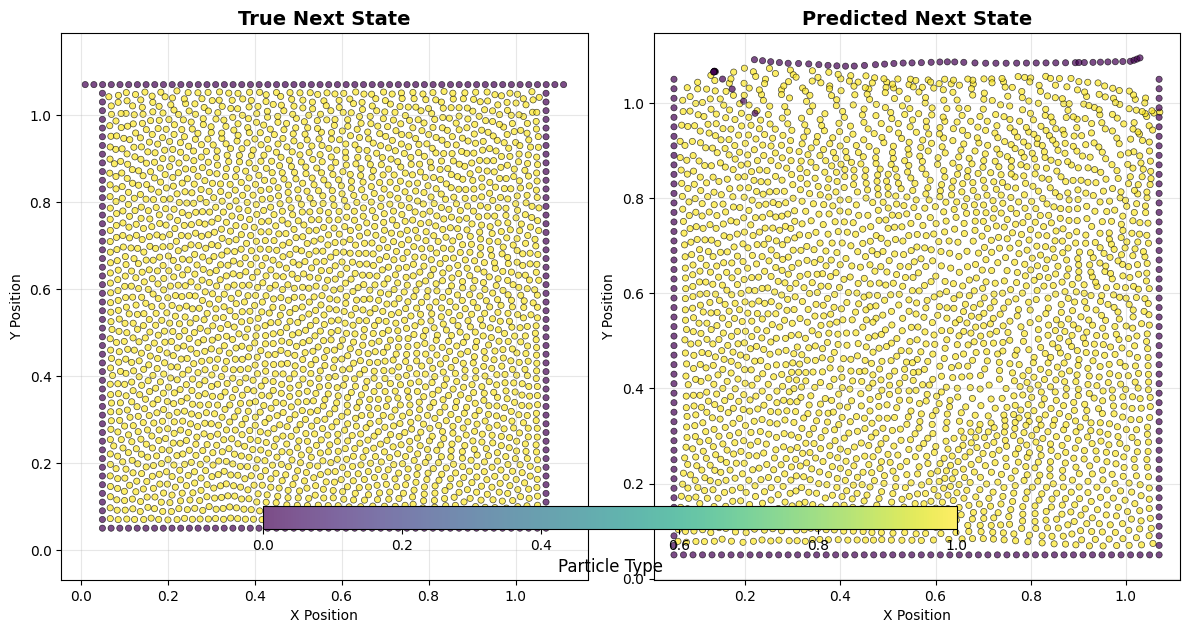

In [201]:
result = visualize_single_prediction_fixed(
        model=model,
        test_loader=test_loader,
        device=device,
        sample_idx=300
    )

## Create animation 

In [ ]:
# # Create GIF from the 20 predictions
# import imageio
# from io import BytesIO

# print("Creating GIF from 20 predictions...")
# try:
#     # First, get all batches from the test loader
#     all_batches = []
#     for batch in test_loader:
#         all_batches.append(batch)
    
#     frames = []
    
#     for i in range(total_frame):
#         print(f"Processing frame {i+1}/{total_frame}")
        
#         # Get the same data as your visualization
#         sample_batch = all_batches[i].to(device)
        
#         with torch.no_grad():
#             pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
        
#         # Extract data (same as your visualization function)
#         true_next_positions = sample_batch.y.cpu()
#         pred_next_positions = pred_positions.cpu()
#         particle_types = sample_batch.x[:, 2:-1].cpu()
        
#         # Get particle colors
#         if particle_types.shape[1] > 1:
#             particle_colors = particle_types[:, 0]
#         else:
#             particle_colors = torch.zeros(len(true_next_positions))
        
#         # Create the same visualization as your function
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
#         # True next state
#         scatter1 = axes[0].scatter(true_next_positions[:, 0], true_next_positions[:, 1], 
#                                   c=particle_colors, s=20, alpha=0.7, 
#                                   cmap='viridis', edgecolor='black', linewidth=0.5,
#                                   vmin=particle_colors.min(), vmax=particle_colors.max())
#         axes[0].set_title(f'True Next State (Frame {i})', fontsize=14, fontweight='bold')
#         axes[0].set_xlabel('X Position')
#         axes[0].set_ylabel('Y Position')
#         axes[0].grid(True, alpha=0.3)
#         axes[0].axis('equal')
        
#         # Predicted next state
#         scatter2 = axes[1].scatter(pred_next_positions[:, 0], pred_next_positions[:, 1], 
#                                   c=particle_colors, s=20, alpha=0.7, 
#                                   cmap='viridis', edgecolor='black', linewidth=0.5,
#                                   vmin=particle_colors.min(), vmax=particle_colors.max())
#         axes[1].set_title(f'Predicted Next State (Frame {i})', fontsize=14, fontweight='bold')
#         axes[1].set_xlabel('X Position')
#         axes[1].set_ylabel('Y Position')
#         axes[1].grid(True, alpha=0.3)
#         axes[1].axis('equal')
        
#         # Add colorbar
#         cbar = plt.colorbar(scatter1, ax=axes, orientation='horizontal', 
#                            pad=0.1, fraction=0.05, aspect=30)
#         cbar.set_label('Particle Type', fontsize=12)
        
#         plt.tight_layout()
        
#         # Save frame to buffer
#         buf = BytesIO()
#         plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
#         buf.seek(0)
#         frames.append(imageio.imread(buf))
#         plt.close()  # Close to save memory
    
#     # Create GIF
#     gif_path = 'dam_simulation_predictions.gif'
#     imageio.mimsave(gif_path, frames, duration=0.8, loop=0)
#     print(f"✅ GIF saved as '{gif_path}'")
#     print(f"📊 Created animation with {len(frames)} frames")
    
# except Exception as e:
#     print(f"❌ Error creating GIF: {e}")
#     import traceback
#     traceback.print_exc()

## Dam break data Collection

In [ ]:
# import pandas as pd
# import time
# import psutil
# import gc
# from typing import Dict, List

# def collect_statistics_summary_only(model, positions, particle_types, device, 
#                                    max_particles=1000, max_timesteps=None, 
#                                    episodes_to_test=None, scenario_name="dam_break") -> pd.DataFrame:
#     """
#     Collect comprehensive inference statistics across multiple episodes - SUMMARY ONLY
    
#     Args:
#         model: Trained GNN model
#         positions: Full position data (episodes, timesteps, particles, 2)
#         particle_types: Particle type data (episodes, particles)
#         device: torch device (cpu/mps/cuda)
#         max_particles: Maximum particles per frame (for subsampling)
#         max_timesteps: Maximum timesteps to process per episode (None = all)
#         episodes_to_test: List of episode indices to test (None = all episodes)
#         scenario_name: Name of the simulation scenario
    
#     Returns:
#         pandas DataFrame with episode-level summary statistics only
#     """
#     model.eval()
    
#     # Determine which episodes to test
#     if episodes_to_test is None:
#         episodes_to_test = list(range(positions.shape[0]))
    
#     print(f"Testing {len(episodes_to_test)} episodes with max {max_particles} particles per frame")
#     print(f"Scenario: {scenario_name}")
#     print(f"Device: {device}")
    
#     # Initialize data collection lists - ONLY for summaries
#     results_data = []
    
#     # Process each episode
#     for episode_idx in episodes_to_test:
#         print(f"\n--- Processing Episode {episode_idx} ---")
        
#         # Get episode data
#         episode_positions = positions[episode_idx]  # (timesteps, particles, 2)
#         episode_particle_types = particle_types[episode_idx]  # (particles,)
        
#         num_timesteps = episode_positions.shape[0] - 1  # -1 because we predict next frame
#         if max_timesteps:
#             num_timesteps = min(num_timesteps, max_timesteps)
        
#         # Initialize episode-level tracking
#         episode_mae_values = []
#         episode_mse_values = []
#         episode_inference_times = []
        
#         # Get baseline memory
#         gc.collect()
#         if device.type == 'mps':
#             torch.mps.empty_cache()
#         elif device.type == 'cuda':
#             torch.cuda.empty_cache()
        
#         process = psutil.Process()
#         baseline_memory_mb = process.memory_info().rss / 1024 / 1024
#         peak_memory_mb = baseline_memory_mb
        
#         # Process each timestep in the episode
#         with torch.no_grad():
#             for t in range(num_timesteps):
#                 if t % 20 == 0:
#                     print(f"  Timestep {t+1}/{num_timesteps}")
                
#                 # Get current and next positions
#                 current_pos = episode_positions[t]
#                 target_pos = episode_positions[t + 1]
                
#                 # Prepare data with subsampling
#                 data = prepare_data_with_subsampling(
#                     current_pos, episode_particle_types, t, target_pos, 
#                     max_particles=max_particles
#                 )
                
#                 # Move to device
#                 data = data.to(device)
#                 actual_particle_count = len(data.x)
                
#                 # Track memory before inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
                
#                 # Time the inference
#                 start_time = time.time()
                
#                 # Forward pass - PURE PREDICTION
#                 predictions = model(data.x, data.edge_index, data.batch)
                
#                 # Ensure computation is complete
#                 if device.type == 'mps':
#                     torch.mps.synchronize()
#                 elif device.type == 'cuda':
#                     torch.cuda.synchronize()
                
#                 end_time = time.time()
#                 inference_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
                
#                 # Calculate errors
#                 true_positions = data.y.cpu()
#                 pred_positions = predictions.cpu()
                
#                 # MAE (Mean Absolute Error)
#                 mae = torch.mean(torch.abs(pred_positions - true_positions)).item()
                
#                 # MSE (Mean Squared Error) 
#                 mse = torch.mean((pred_positions - true_positions) ** 2).item()
                
#                 # Store timestep-level data for averaging (NOT in final dataframe)
#                 episode_mae_values.append(mae)
#                 episode_mse_values.append(mse)
#                 episode_inference_times.append(inference_time_ms)
                
#                 # Track memory after inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
        
#         # Calculate episode-level aggregated statistics
#         episode_mae_values = torch.tensor(episode_mae_values)
#         episode_mse_values = torch.tensor(episode_mse_values)
#         episode_inference_times = torch.tensor(episode_inference_times)
        
#         total_episode_time_ms = episode_inference_times.sum().item()
#         avg_time_per_step_ms = episode_inference_times.mean().item()
#         throughput_fps = 1000.0 / avg_time_per_step_ms  # Convert ms to FPS
#         memory_overhead_mb = peak_memory_mb - baseline_memory_mb
        
#         # Store ONLY episode-level summary (ONE ROW PER EPISODE)
#         results_data.append({
#             'scenario': scenario_name,
#             'episode': episode_idx,
#             'particle_count': actual_particle_count,
#             'max_particles_setting': max_particles,
#             'MAE': episode_mae_values.mean().item(),
#             'MSE': episode_mse_values.mean().item(),
#             'RMSE': episode_mse_values.mean().item() ** 0.5,
#             'total_inference_time_ms': total_episode_time_ms,
#             'avg_time_per_step_ms': avg_time_per_step_ms,
#             'throughput_fps': throughput_fps,
#             'peak_memory_mb': peak_memory_mb,
#             'baseline_memory_mb': baseline_memory_mb,
#             'memory_overhead_mb': memory_overhead_mb,
#             'total_timesteps': num_timesteps,
#             'device': str(device)
#         })
        
#         print(f"  Episode {episode_idx} completed:")
#         print(f"    Avg MAE: {episode_mae_values.mean().item():.6f}")
#         print(f"    Avg MSE: {episode_mse_values.mean().item():.6f}")
#         print(f"    Avg inference time: {avg_time_per_step_ms:.3f} ms/step")
#         print(f"    Throughput: {throughput_fps:.2f} FPS")
#         print(f"    Memory overhead: {memory_overhead_mb:.2f} MB")
    
#     # Convert to DataFrame
#     df = pd.DataFrame(results_data)
    
#     # Display summary statistics
#     print("\n" + "="*80)
#     print("COMPREHENSIVE INFERENCE STATISTICS SUMMARY")
#     print("="*80)
    
#     if len(df) > 0:
#         print(f"Scenario: {scenario_name}")
#         print(f"Episodes tested: {len(df)}")
#         print(f"Particle count per frame: {df['particle_count'].iloc[0]}")
#         print(f"Device: {device}")
#         print()
#         print("ACCURACY METRICS (across all episodes):")
#         print(f"  Mean MAE:         {df['MAE'].mean():.6f} ± {df['MAE'].std():.6f}")
#         print(f"  Mean MSE:         {df['MSE'].mean():.6f} ± {df['MSE'].std():.6f}")
#         print(f"  Mean RMSE:        {df['RMSE'].mean():.6f} ± {df['RMSE'].std():.6f}")
#         print()
#         print("PERFORMANCE METRICS (across all episodes):")
#         print(f"  Avg time per step: {df['avg_time_per_step_ms'].mean():.3f} ± {df['avg_time_per_step_ms'].std():.3f} ms")
#         print(f"  Avg throughput:    {df['throughput_fps'].mean():.2f} ± {df['throughput_fps'].std():.2f} FPS")
#         print(f"  Peak memory:       {df['peak_memory_mb'].mean():.2f} ± {df['peak_memory_mb'].std():.2f} MB")
#         print(f"  Memory overhead:   {df['memory_overhead_mb'].mean():.2f} ± {df['memory_overhead_mb'].std():.2f} MB")
    
#     print("="*80)
    
#     return df

# # Run comprehensive statistics collection with multiple runs - SUMMARY ONLY
# print("Starting comprehensive inference statistics collection (SUMMARY ONLY)...")

# # Test with different particle counts for comparison
# test_configurations = [
#     {'max_particles': 1000, 'scenario_name': 'dam_break_1000p'},
#     {'max_particles': 2000, 'scenario_name': 'dam_break_2000p'},
#     {'max_particles': 3000, 'scenario_name': 'dam_break_3000p'},
#     {'max_particles': 5000, 'scenario_name': 'dam_break_3000p'}
# ]

# all_results = []

# # Multiple runs for statistical significance
# num_runs = 5  # Add 5 runs per configuration

# for run_id in range(num_runs):
#     for config in test_configurations:
#         print(f"\n{'='*60}")
#         print(f"RUN {run_id + 1}/{num_runs} - Testing configuration: {config['scenario_name']}")
#         print(f"{'='*60}")
        
#         df_config = collect_statistics_summary_only(
#             model=model,
#             positions=positions,
#             particle_types=particle_types,
#             device=device,
#             max_particles=config['max_particles'],
#             max_timesteps=30,  # Test first 30 timesteps per episode
#             episodes_to_test=[0],  # Test only 1 episode per run
#             scenario_name=f"{config['scenario_name']}_run{run_id+1}"  # Add run ID to scenario name
#         )
        
#         # Add run information to the dataframe
#         df_config['run_id'] = run_id + 1
#         df_config['base_scenario'] = config['scenario_name']
        
#         all_results.append(df_config)

# # Combine all results
# inference_statistics_df = pd.concat(all_results, ignore_index=True)

# print(f"\n✅ Complete statistics with {num_runs} runs per configuration")
# print(f"📊 Total records: {len(inference_statistics_df)}")
# print(f"🔄 Total runs: {num_runs * len(test_configurations)} = {num_runs} runs × {len(test_configurations)} configs")

# # Save to CSV for later analysis
# csv_filename = 'gnn_inference_statistics_summary.csv'
# inference_statistics_df.to_csv(csv_filename, index=False)
# print(f"\n✅ Summary statistics saved to '{csv_filename}'")

## Lid driven data collection

In [ ]:
# import pandas as pd
# import time
# import psutil
# import gc
# from typing import Dict, List

# def collect_statistics_summary_only(model, positions, particle_types, device, 
#                                    max_particles=1000, max_timesteps=None, 
#                                    episodes_to_test=None, scenario_name="lid_driven_cavity") -> pd.DataFrame:
#     """
#     Collect comprehensive inference statistics across multiple episodes - SUMMARY ONLY
    
#     Args:
#         model: Trained GNN model
#         positions: Full position data (episodes, timesteps, particles, 2)
#         particle_types: Particle type data (episodes, particles)
#         device: torch device (cpu/mps/cuda)
#         max_particles: Maximum particles per frame (for subsampling)
#         max_timesteps: Maximum timesteps to process per episode (None = all)
#         episodes_to_test: List of episode indices to test (None = all episodes)
#         scenario_name: Name of the simulation scenario
    
#     Returns:
#         pandas DataFrame with episode-level summary statistics only
#     """
#     model.eval()
    
#     # Determine which episodes to test
#     if episodes_to_test is None:
#         episodes_to_test = list(range(positions.shape[0]))
    
#     print(f"Testing {len(episodes_to_test)} episodes with max {max_particles} particles per frame")
#     print(f"Scenario: {scenario_name}")
#     print(f"Device: {device}")
    
#     # Initialize data collection lists - ONLY for summaries
#     results_data = []
    
#     # Process each episode
#     for episode_idx in episodes_to_test:
#         print(f"\n--- Processing Episode {episode_idx} ---")
        
#         # Get episode data
#         episode_positions = positions[episode_idx]  # (timesteps, particles, 2)
#         episode_particle_types = particle_types[episode_idx]  # (particles,)
        
#         num_timesteps = episode_positions.shape[0] - 1  # -1 because we predict next frame
#         if max_timesteps:
#             num_timesteps = min(num_timesteps, max_timesteps)
        
#         # Initialize episode-level tracking
#         episode_mae_values = []
#         episode_mse_values = []
#         episode_inference_times = []
        
#         # Get baseline memory
#         gc.collect()
#         if device.type == 'mps':
#             torch.mps.empty_cache()
#         elif device.type == 'cuda':
#             torch.cuda.empty_cache()
        
#         process = psutil.Process()
#         baseline_memory_mb = process.memory_info().rss / 1024 / 1024
#         peak_memory_mb = baseline_memory_mb
        
#         # Process each timestep in the episode
#         with torch.no_grad():
#             for t in range(num_timesteps):
#                 if t % 20 == 0:
#                     print(f"  Timestep {t+1}/{num_timesteps}")
                
#                 # Get current and next positions
#                 current_pos = episode_positions[t]
#                 target_pos = episode_positions[t + 1]
                
#                 # Prepare data with subsampling
#                 data = prepare_data_with_subsampling(
#                     current_pos, episode_particle_types, t, target_pos, 
#                     max_particles=max_particles
#                 )
                
#                 # Move to device
#                 data = data.to(device)
#                 actual_particle_count = len(data.x)
                
#                 # Track memory before inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
                
#                 # Time the inference
#                 start_time = time.time()
                
#                 # Forward pass - PURE PREDICTION
#                 predictions = model(data.x, data.edge_index, data.batch)
                
#                 # Ensure computation is complete
#                 if device.type == 'mps':
#                     torch.mps.synchronize()
#                 elif device.type == 'cuda':
#                     torch.cuda.synchronize()
                
#                 end_time = time.time()
#                 inference_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
                
#                 # Calculate errors
#                 true_positions = data.y.cpu()
#                 pred_positions = predictions.cpu()
                
#                 # MAE (Mean Absolute Error)
#                 mae = torch.mean(torch.abs(pred_positions - true_positions)).item()
                
#                 # MSE (Mean Squared Error) 
#                 mse = torch.mean((pred_positions - true_positions) ** 2).item()
                
#                 # Store timestep-level data for averaging (NOT in final dataframe)
#                 episode_mae_values.append(mae)
#                 episode_mse_values.append(mse)
#                 episode_inference_times.append(inference_time_ms)
                
#                 # Track memory after inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
        
#         # Calculate episode-level aggregated statistics
#         episode_mae_values = torch.tensor(episode_mae_values)
#         episode_mse_values = torch.tensor(episode_mse_values)
#         episode_inference_times = torch.tensor(episode_inference_times)
        
#         total_episode_time_ms = episode_inference_times.sum().item()
#         avg_time_per_step_ms = episode_inference_times.mean().item()
#         throughput_fps = 1000.0 / avg_time_per_step_ms  # Convert ms to FPS
#         memory_overhead_mb = peak_memory_mb - baseline_memory_mb
        
#         # Store ONLY episode-level summary (ONE ROW PER EPISODE)
#         results_data.append({
#             'scenario': scenario_name,
#             'episode': episode_idx,
#             'particle_count': actual_particle_count,
#             'max_particles_setting': max_particles,
#             'MAE': episode_mae_values.mean().item(),
#             'MSE': episode_mse_values.mean().item(),
#             'RMSE': episode_mse_values.mean().item() ** 0.5,
#             'total_inference_time_ms': total_episode_time_ms,
#             'avg_time_per_step_ms': avg_time_per_step_ms,
#             'throughput_fps': throughput_fps,
#             'peak_memory_mb': peak_memory_mb,
#             'baseline_memory_mb': baseline_memory_mb,
#             'memory_overhead_mb': memory_overhead_mb,
#             'total_timesteps': num_timesteps,
#             'device': str(device)
#         })
        
#         print(f"  Episode {episode_idx} completed:")
#         print(f"    Avg MAE: {episode_mae_values.mean().item():.6f}")
#         print(f"    Avg MSE: {episode_mse_values.mean().item():.6f}")
#         print(f"    Avg inference time: {avg_time_per_step_ms:.3f} ms/step")
#         print(f"    Throughput: {throughput_fps:.2f} FPS")
#         print(f"    Memory overhead: {memory_overhead_mb:.2f} MB")
    
#     # Convert to DataFrame
#     df = pd.DataFrame(results_data)
    
#     # Display summary statistics
#     print("\n" + "="*80)
#     print("COMPREHENSIVE INFERENCE STATISTICS SUMMARY")
#     print("="*80)
    
#     if len(df) > 0:
#         print(f"Scenario: {scenario_name}")
#         print(f"Episodes tested: {len(df)}")
#         print(f"Particle count per frame: {df['particle_count'].iloc[0]}")
#         print(f"Device: {device}")
#         print()
#         print("ACCURACY METRICS (across all episodes):")
#         print(f"  Mean MAE:         {df['MAE'].mean():.6f} ± {df['MAE'].std():.6f}")
#         print(f"  Mean MSE:         {df['MSE'].mean():.6f} ± {df['MSE'].std():.6f}")
#         print(f"  Mean RMSE:        {df['RMSE'].mean():.6f} ± {df['RMSE'].std():.6f}")
#         print()
#         print("PERFORMANCE METRICS (across all episodes):")
#         print(f"  Avg time per step: {df['avg_time_per_step_ms'].mean():.3f} ± {df['avg_time_per_step_ms'].std():.3f} ms")
#         print(f"  Avg throughput:    {df['throughput_fps'].mean():.2f} ± {df['throughput_fps'].std():.2f} FPS")
#         print(f"  Peak memory:       {df['peak_memory_mb'].mean():.2f} ± {df['peak_memory_mb'].std():.2f} MB")
#         print(f"  Memory overhead:   {df['memory_overhead_mb'].mean():.2f} ± {df['memory_overhead_mb'].std():.2f} MB")
    
#     print("="*80)
    
#     return df

# # Run comprehensive statistics collection with multiple runs - SUMMARY ONLY
# print("Starting comprehensive inference statistics collection (SUMMARY ONLY)...")

# # Test with different particle counts for comparison - Updated for Lid Driven Cavity
# test_configurations = [
#     {'max_particles': 1000, 'scenario_name': 'ldc_1000p'},
#     {'max_particles': 2000, 'scenario_name': 'ldc_2000p'},
#     {'max_particles': 3000, 'scenario_name': 'ldc_3000p'},
#     {'max_particles': 5000, 'scenario_name': 'ldc_5000p'}
# ]

# all_results = []

# # Multiple runs for statistical significance
# num_runs = 5  # Add 5 runs per configuration

# for run_id in range(num_runs):
#     for config in test_configurations:
#         print(f"\n{'='*60}")
#         print(f"RUN {run_id + 1}/{num_runs} - Testing configuration: {config['scenario_name']}")
#         print(f"{'='*60}")
        
#         df_config = collect_statistics_summary_only(
#             model=model,
#             positions=positions,
#             particle_types=particle_types,
#             device=device,
#             max_particles=config['max_particles'],
#             max_timesteps=30,  # Test first 30 timesteps per episode
#             episodes_to_test=[0],  # Test only 1 episode per run
#             scenario_name=f"{config['scenario_name']}_run{run_id+1}"  # Add run ID to scenario name
#         )
        
#         # Add run information to the dataframe
#         df_config['run_id'] = run_id + 1
#         df_config['base_scenario'] = config['scenario_name']
        
#         all_results.append(df_config)

# # Combine all results
# inference_statistics_df = pd.concat(all_results, ignore_index=True)

# print(f"\n✅ Complete statistics with {num_runs} runs per configuration")
# print(f"📊 Total records: {len(inference_statistics_df)}")
# print(f"🔄 Total runs: {num_runs * len(test_configurations)} = {num_runs} runs × {len(test_configurations)} configs")

# # Save to CSV for later analysis - Updated filename for LDC
# csv_filename = 'gnn_ldc_inference_statistics_summary.csv'
# inference_statistics_df.to_csv(csv_filename, index=False)
# print(f"\n✅ Summary statistics saved to '{csv_filename}'")

## RRF data collection

In [ ]:
# import pandas as pd
# import time
# import psutil
# import gc
# from typing import Dict, List

# def collect_statistics_summary_only(model, positions, particle_types, device, 
#                                    max_particles=1000, max_timesteps=None, 
#                                    episodes_to_test=None, scenario_name="rpf") -> pd.DataFrame:
#     """
#     Collect comprehensive inference statistics across multiple episodes - SUMMARY ONLY
    
#     Args:
#         model: Trained GNN model
#         positions: Full position data (episodes, timesteps, particles, 2)
#         particle_types: Particle type data (episodes, particles)
#         device: torch device (cpu/mps/cuda)
#         max_particles: Maximum particles per frame (for subsampling)
#         max_timesteps: Maximum timesteps to process per episode (None = all)
#         episodes_to_test: List of episode indices to test (None = all episodes)
#         scenario_name: Name of the simulation scenario
    
#     Returns:
#         pandas DataFrame with episode-level summary statistics only
#     """
#     model.eval()
    
#     # Determine which episodes to test
#     if episodes_to_test is None:
#         episodes_to_test = list(range(positions.shape[0]))
    
#     print(f"Testing {len(episodes_to_test)} episodes with max {max_particles} particles per frame")
#     print(f"Scenario: {scenario_name}")
#     print(f"Device: {device}")
    
#     # Initialize data collection lists - ONLY for summaries
#     results_data = []
    
#     # Process each episode
#     for episode_idx in episodes_to_test:
#         print(f"\n--- Processing Episode {episode_idx} ---")
        
#         # Get episode data
#         episode_positions = positions[episode_idx]  # (timesteps, particles, 2)
#         episode_particle_types = particle_types[episode_idx]  # (particles,)
        
#         num_timesteps = episode_positions.shape[0] - 1  # -1 because we predict next frame
#         if max_timesteps:
#             num_timesteps = min(num_timesteps, max_timesteps)
        
#         # Initialize episode-level tracking
#         episode_mae_values = []
#         episode_mse_values = []
#         episode_inference_times = []
        
#         # Get baseline memory
#         gc.collect()
#         if device.type == 'mps':
#             torch.mps.empty_cache()
#         elif device.type == 'cuda':
#             torch.cuda.empty_cache()
        
#         process = psutil.Process()
#         baseline_memory_mb = process.memory_info().rss / 1024 / 1024
#         peak_memory_mb = baseline_memory_mb
        
#         # Process each timestep in the episode
#         with torch.no_grad():
#             for t in range(num_timesteps):
#                 if t % 20 == 0:
#                     print(f"  Timestep {t+1}/{num_timesteps}")
                
#                 # Get current and next positions
#                 current_pos = episode_positions[t]
#                 target_pos = episode_positions[t + 1]
                
#                 # Prepare data with subsampling - USING 4-FEATURE FORMAT
#                 # Convert to the 4-feature format for RPF
#                 if len(current_pos) > max_particles:
#                     # Subsampling needed
#                     data = prepare_data_with_subsampling(
#                         current_pos, episode_particle_types, t, target_pos, 
#                         max_particles=max_particles
#                     )
#                 else:
#                     # No subsampling needed - use regular prepare_data
#                     data = prepare_data(
#                         current_pos, episode_particle_types, t, target_pos
#                     )
                
#                 # Move to device
#                 data = data.to(device)
#                 actual_particle_count = len(data.x)
                
#                 # Track memory before inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
                
#                 # Time the inference
#                 start_time = time.time()
                
#                 # Forward pass - PURE PREDICTION
#                 predictions = model(data.x, data.edge_index, data.batch)
                
#                 # Ensure computation is complete
#                 if device.type == 'mps':
#                     torch.mps.synchronize()
#                 elif device.type == 'cuda':
#                     torch.cuda.synchronize()
                
#                 end_time = time.time()
#                 inference_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
                
#                 # Calculate errors
#                 true_positions = data.y.cpu()
#                 pred_positions = predictions.cpu()
                
#                 # MAE (Mean Absolute Error)
#                 mae = torch.mean(torch.abs(pred_positions - true_positions)).item()
                
#                 # MSE (Mean Squared Error) 
#                 mse = torch.mean((pred_positions - true_positions) ** 2).item()
                
#                 # Store timestep-level data for averaging (NOT in final dataframe)
#                 episode_mae_values.append(mae)
#                 episode_mse_values.append(mse)
#                 episode_inference_times.append(inference_time_ms)
                
#                 # Track memory after inference
#                 current_memory = process.memory_info().rss / 1024 / 1024
#                 peak_memory_mb = max(peak_memory_mb, current_memory)
        
#         # Calculate episode-level aggregated statistics
#         episode_mae_values = torch.tensor(episode_mae_values)
#         episode_mse_values = torch.tensor(episode_mse_values)
#         episode_inference_times = torch.tensor(episode_inference_times)
        
#         total_episode_time_ms = episode_inference_times.sum().item()
#         avg_time_per_step_ms = episode_inference_times.mean().item()
#         throughput_fps = 1000.0 / avg_time_per_step_ms  # Convert ms to FPS
#         memory_overhead_mb = peak_memory_mb - baseline_memory_mb
        
#         # Store ONLY episode-level summary (ONE ROW PER EPISODE)
#         results_data.append({
#             'scenario': scenario_name,
#             'episode': episode_idx,
#             'particle_count': actual_particle_count,
#             'max_particles_setting': max_particles,
#             'MAE': episode_mae_values.mean().item(),
#             'MSE': episode_mse_values.mean().item(),
#             'RMSE': episode_mse_values.mean().item() ** 0.5,
#             'total_inference_time_ms': total_episode_time_ms,
#             'avg_time_per_step_ms': avg_time_per_step_ms,
#             'throughput_fps': throughput_fps,
#             'peak_memory_mb': peak_memory_mb,
#             'baseline_memory_mb': baseline_memory_mb,
#             'memory_overhead_mb': memory_overhead_mb,
#             'total_timesteps': num_timesteps,
#             'device': str(device)
#         })
        
#         print(f"  Episode {episode_idx} completed:")
#         print(f"    Avg MAE: {episode_mae_values.mean().item():.6f}")
#         print(f"    Avg MSE: {episode_mse_values.mean().item():.6f}")
#         print(f"    Avg inference time: {avg_time_per_step_ms:.3f} ms/step")
#         print(f"    Throughput: {throughput_fps:.2f} FPS")
#         print(f"    Memory overhead: {memory_overhead_mb:.2f} MB")
    
#     # Convert to DataFrame
#     df = pd.DataFrame(results_data)
    
#     # Display summary statistics
#     print("\n" + "="*80)
#     print("COMPREHENSIVE INFERENCE STATISTICS SUMMARY")
#     print("="*80)
    
#     if len(df) > 0:
#         print(f"Scenario: {scenario_name}")
#         print(f"Episodes tested: {len(df)}")
#         print(f"Particle count per frame: {df['particle_count'].iloc[0]}")
#         print(f"Device: {device}")
#         print()
#         print("ACCURACY METRICS (across all episodes):")
#         print(f"  Mean MAE:         {df['MAE'].mean():.6f} ± {df['MAE'].std():.6f}")
#         print(f"  Mean MSE:         {df['MSE'].mean():.6f} ± {df['MSE'].std():.6f}")
#         print(f"  Mean RMSE:        {df['RMSE'].mean():.6f} ± {df['RMSE'].std():.6f}")
#         print()
#         print("PERFORMANCE METRICS (across all episodes):")
#         print(f"  Avg time per step: {df['avg_time_per_step_ms'].mean():.3f} ± {df['avg_time_per_step_ms'].std():.3f} ms")
#         print(f"  Avg throughput:    {df['throughput_fps'].mean():.2f} ± {df['throughput_fps'].std():.2f} FPS")
#         print(f"  Peak memory:       {df['peak_memory_mb'].mean():.2f} ± {df['peak_memory_mb'].std():.2f} MB")
#         print(f"  Memory overhead:   {df['memory_overhead_mb'].mean():.2f} ± {df['memory_overhead_mb'].std():.2f} MB")
    
#     print("="*80)
    
#     return df

# # Run comprehensive statistics collection with multiple runs - SUMMARY ONLY
# print("Starting comprehensive inference statistics collection (SUMMARY ONLY)...")

# # Test with different particle counts for comparison - Updated for RPF scenario
# test_configurations = [
#     {'max_particles': 1000, 'scenario_name': 'rpf_1000p'},
#     {'max_particles': 2000, 'scenario_name': 'rpf_2000p'},
#     {'max_particles': 3000, 'scenario_name': 'rpf_3000p'},
# ]

# all_results = []

# # Multiple runs for statistical significance
# num_runs = 5  # Add 5 runs per configuration

# for run_id in range(num_runs):
#     for config in test_configurations:
#         print(f"\n{'='*60}")
#         print(f"RUN {run_id + 1}/{num_runs} - Testing configuration: {config['scenario_name']}")
#         print(f"{'='*60}")
        
#         df_config = collect_statistics_summary_only(
#             model=model,
#             positions=positions,
#             particle_types=particle_types,
#             device=device,
#             max_particles=config['max_particles'],
#             max_timesteps=30,  # Test first 30 timesteps per episode
#             episodes_to_test=[0],  # Test only 1 episode per run
#             scenario_name=f"{config['scenario_name']}_run{run_id+1}"  # Add run ID to scenario name
#         )
        
#         # Add run information to the dataframe
#         df_config['run_id'] = run_id + 1
#         df_config['base_scenario'] = config['scenario_name']
        
#         all_results.append(df_config)

# # Combine all results
# inference_statistics_df = pd.concat(all_results, ignore_index=True)

# print(f"\n✅ Complete statistics with {num_runs} runs per configuration")
# print(f"📊 Total records: {len(inference_statistics_df)}")
# print(f"🔄 Total runs: {num_runs * len(test_configurations)} = {num_runs} runs × {len(test_configurations)} configs")

# # Save to CSV for later analysis - Updated filename for RPF
# csv_filename = 'gnn_rpf_inference_statistics_summary.csv'
# inference_statistics_df.to_csv(csv_filename, index=False)
# print(f"\n✅ Summary statistics saved to '{csv_filename}'")

Starting comprehensive inference statistics collection (SUMMARY ONLY)...

RUN 1/5 - Testing configuration: rpf_1000p
Testing 1 episodes with max 1000 particles per frame
Scenario: rpf_1000p_run1
Device: mps

--- Processing Episode 0 ---
  Timestep 1/30
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created features with shape: torch.Size([1000, 4]) (should be Nx4)
Created fe

In [208]:
from pathlib import Path

DATA_PATH = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/stats/gnn_ldc_rollout_statistics.csv'
is_valid = Path(DATA_PATH).exists()
print(f"File path is {'valid' if is_valid else 'invalid'}")

File path is valid



Normality Test Results for MAE:
--------------------------------------------------


KeyError: 'particle_count'

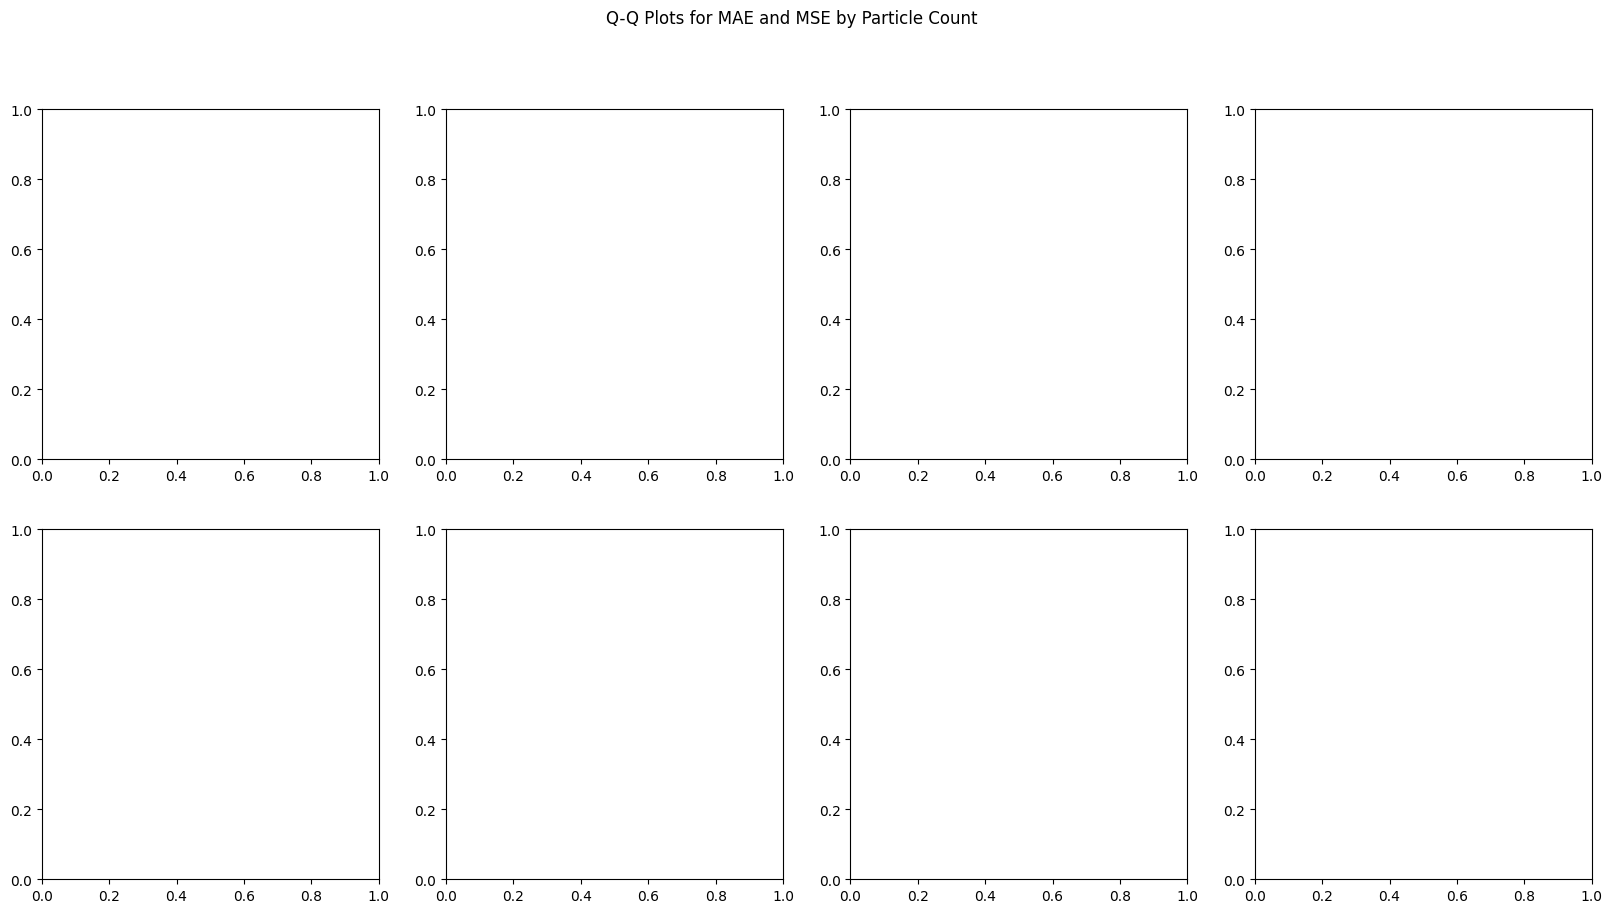

In [209]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv(DATA_PATH)

# Create figure for Q-Q plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Q-Q Plots for MAE and MSE by Particle Count')

# Dictionary to store test results
normality_results = {}

# Metrics to test
metrics = ['MAE', 'MSE']

# Particle counts to analyze
particle_counts = [1000, 2000, 3000, 5000]

# Perform normality tests and create Q-Q plots
for i, metric in enumerate(metrics):
    print(f"\nNormality Test Results for {metric}:")
    print("-" * 50)
    
    for j, count in enumerate(particle_counts):
        # Filter data for current particle count
        data = df[df['particle_count'] == count][metric]
        
        # Perform Shapiro-Wilk test
        statistic, p_value = stats.shapiro(data)
        
        # Store results
        normality_results[f"{metric}_{count}"] = {
            'statistic': statistic,
            'p_value': p_value
        }
        
        # Print results
        print(f"\nParticle Count: {count}")
        print(f"Shapiro-Wilk test statistic: {statistic:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Normal distribution? {'Yes' if p_value > 0.05 else 'No'}")
        
        # Create Q-Q plot
        stats.probplot(data, dist="norm", plot=axes[i, j])
        axes[i, j].set_title(f"{metric} - {count}k particles")

plt.tight_layout()
plt.show()

# Create box plots for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot for MAE
sns.boxplot(x='particle_count', y='MAE', data=df, ax=ax1)
ax1.set_title('MAE Distribution by Particle Count')
ax1.set_xlabel('Particle Count')
ax1.set_ylabel('MAE')

# Box plot for MSE
sns.boxplot(x='particle_count', y='MSE', data=df, ax=ax2)
ax2.set_title('MSE Distribution by Particle Count')
ax2.set_xlabel('Particle Count')
ax2.set_ylabel('MSE')

plt.tight_layout()
plt.show()

In [206]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Read the CSV file
df = pd.read_csv(DATA_PATH)

# Perform one-way ANOVA for MAE
print("One-way ANOVA Results for MAE:")
print("-" * 50)
groups_mae = [group for _, group in df.groupby('particle_count')['MAE']]
f_statistic_mae, p_value_mae = stats.f_oneway(*groups_mae)
print(f"F-statistic: {f_statistic_mae:.4f}")
print(f"p-value: {p_value_mae:.4f}")
print(f"Significant differences exist? {'Yes' if p_value_mae < 0.05 else 'No'}\n")

# Perform one-way ANOVA for MSE
print("One-way ANOVA Results for MSE:")
print("-" * 50)
groups_mse = [group for _, group in df.groupby('particle_count')['MSE']]
f_statistic_mse, p_value_mse = stats.f_oneway(*groups_mse)
print(f"F-statistic: {f_statistic_mse:.4f}")
print(f"p-value: {p_value_mse:.4f}")
print(f"Significant differences exist? {'Yes' if p_value_mse < 0.05 else 'No'}\n")

# Perform Tukey's HSD test for MAE
print("Tukey's HSD Test Results for MAE:")
print("-" * 50)
tukey_mae = pairwise_tukeyhsd(df['MAE'], df['particle_count'])
print(tukey_mae)
print("\n")

# Perform Tukey's HSD test for MSE
print("Tukey's HSD Test Results for MSE:")
print("-" * 50)
tukey_mse = pairwise_tukeyhsd(df['MSE'], df['particle_count'])
print(tukey_mse)


# Print descriptive statistics
print("\nDescriptive Statistics:")
print("-" * 50)
print("\nMAE Statistics by Particle Count:")
print(df.groupby('particle_count')['MAE'].describe())
print("\nMSE Statistics by Particle Count:")
print(df.groupby('particle_count')['MSE'].describe())

One-way ANOVA Results for MAE:
--------------------------------------------------
F-statistic: 7095.2602
p-value: 0.0000
Significant differences exist? Yes

One-way ANOVA Results for MSE:
--------------------------------------------------
F-statistic: 3569.8064
p-value: 0.0000
Significant differences exist? Yes

Tukey's HSD Test Results for MAE:
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
  1000   2000   0.0009   0.0 0.0008  0.001   True
  1000   3000   0.0018   0.0 0.0018 0.0019   True
  1000   5000   0.0035   0.0 0.0034 0.0035   True
  2000   3000   0.0009   0.0 0.0009  0.001   True
  2000   5000   0.0026   0.0 0.0025 0.0026   True
  3000   5000   0.0016   0.0 0.0016 0.0017   True
-------------------------------------------------


Tukey's HSD Test Results for MSE:
--------------------------------------------------
Multiple Com

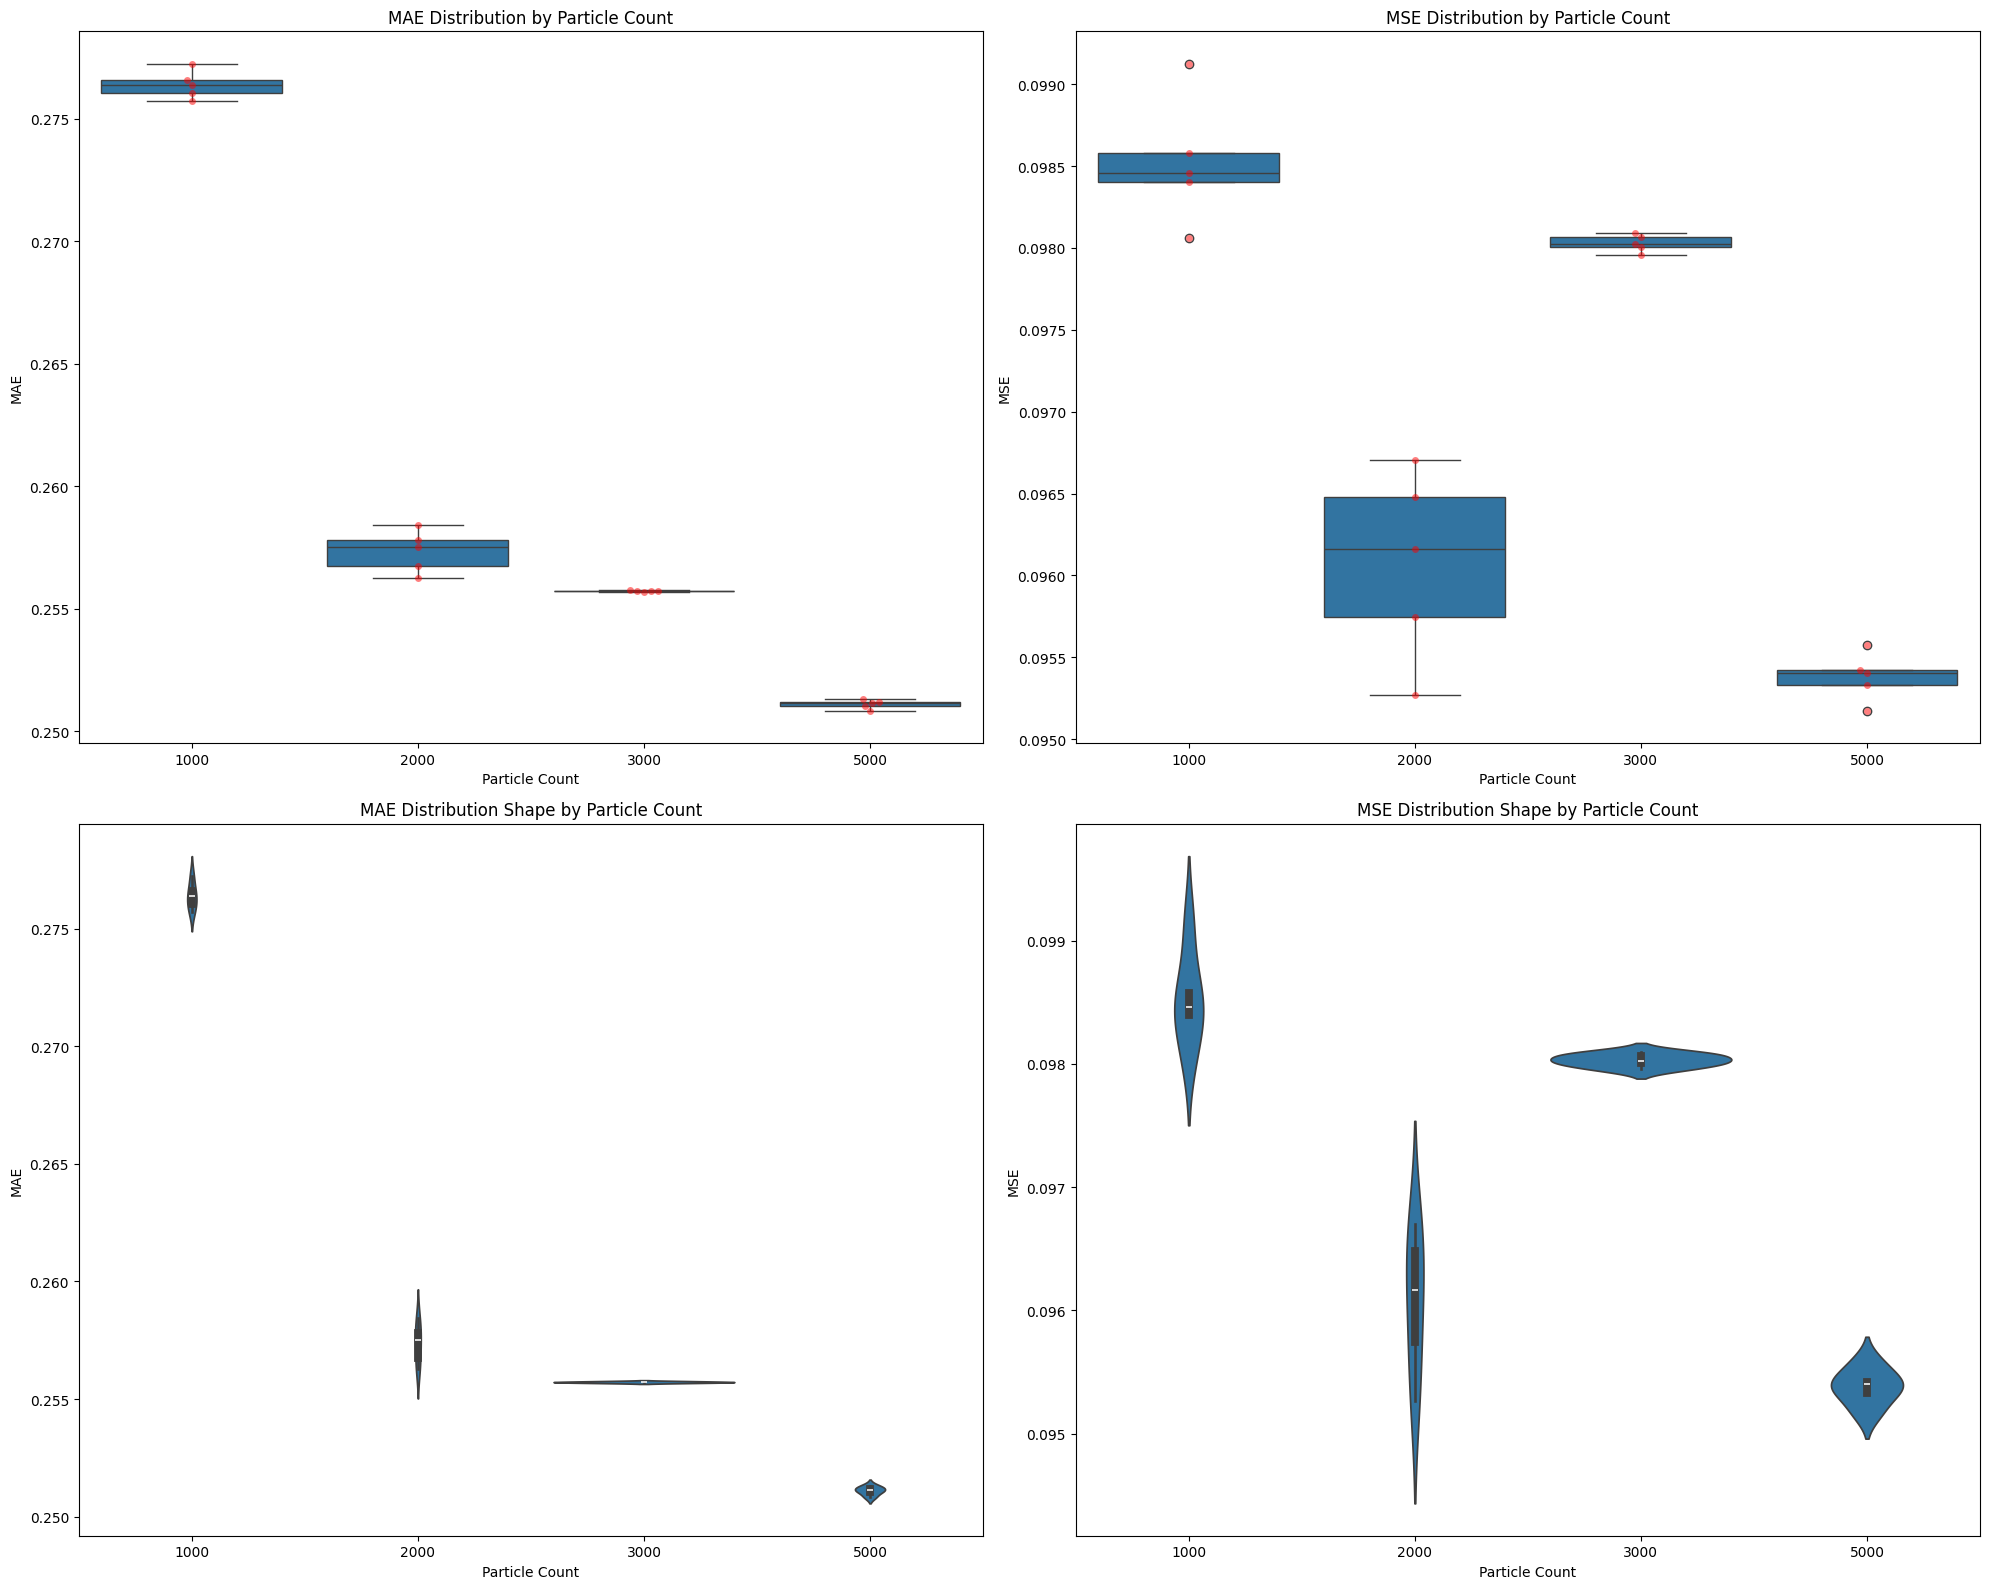


Detailed Statistical Summary

MAE Analysis:
--------------------------------------------------

MAE Summary Statistics:
                    mean       std       min       max
particle_count                                        
1000            0.276393  0.000577  0.275726  0.277244
2000            0.257356  0.000855  0.256266  0.258426
3000            0.255722  0.000029  0.255684  0.255761
5000            0.251102  0.000182  0.250829  0.251311

MAE Effect Sizes (Cohen's d):
1000 vs 2000: 26.0997
1000 vs 3000: 50.5677
1000 vs 5000: 59.0767
2000 vs 3000: 2.7031
2000 vs 5000: 10.1204
3000 vs 5000: 35.4405

MSE Analysis:
--------------------------------------------------

MSE Summary Statistics:
                    mean       std       min       max
particle_count                                        
1000            0.098526  0.000386  0.098063  0.099126
2000            0.096072  0.000576  0.095269  0.096704
3000            0.098030  0.000053  0.097958  0.098093
5000            0.095

In [186]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv(DATA_PATH)

# Function to calculate Cohen's d
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d
    return (np.mean(group1) - np.mean(group2)) / pooled_se

# Calculate effect sizes between all groups
def calculate_all_effect_sizes(data, metric):
    particle_counts = [1000, 2000, 3000, 5000]
    effect_sizes = {}
    for i in range(len(particle_counts)):
        for j in range(i+1, len(particle_counts)):
            group1 = data[data['particle_count'] == particle_counts[i]][metric]
            group2 = data[data['particle_count'] == particle_counts[j]][metric]
            effect_size = cohens_d(group1, group2)
            effect_sizes[f"{particle_counts[i]} vs {particle_counts[j]}"] = effect_size
    return effect_sizes

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Box plots with individual points
sns.boxplot(x='particle_count', y='MAE', data=df, ax=ax1)
sns.swarmplot(x='particle_count', y='MAE', data=df, color='red', alpha=0.5, ax=ax1)
ax1.set_title('MAE Distribution by Particle Count')
ax1.set_xlabel('Particle Count')
ax1.set_ylabel('MAE')

sns.boxplot(x='particle_count', y='MSE', data=df, ax=ax2)
sns.swarmplot(x='particle_count', y='MSE', data=df, color='red', alpha=0.5, ax=ax2)
ax2.set_title('MSE Distribution by Particle Count')
ax2.set_xlabel('Particle Count')
ax2.set_ylabel('MSE')

# 2. Violin plots for distribution shape
sns.violinplot(x='particle_count', y='MAE', data=df, ax=ax3)
ax3.set_title('MAE Distribution Shape by Particle Count')
ax3.set_xlabel('Particle Count')
ax3.set_ylabel('MAE')

sns.violinplot(x='particle_count', y='MSE', data=df, ax=ax4)
ax4.set_title('MSE Distribution Shape by Particle Count')
ax4.set_xlabel('Particle Count')
ax4.set_ylabel('MSE')

plt.tight_layout()
plt.show()

# Calculate effect sizes
mae_effect_sizes = calculate_all_effect_sizes(df, 'MAE')
mse_effect_sizes = calculate_all_effect_sizes(df, 'MSE')

# Print detailed statistical summary
print("\nDetailed Statistical Summary")
print("=" * 50)

# Calculate percentage differences from baseline (1000 particles)
def calculate_percentage_differences(data, metric):
    base = data[data['particle_count'] == 1000][metric].mean()
    particle_counts = [1000, 2000, 3000, 5000]
    differences = {}
    for count in particle_counts:
        current = data[data['particle_count'] == count][metric].mean()
        pct_diff = ((current - base) / base) * 100
        differences[count] = pct_diff
    return differences

# Calculate and print summary statistics
print("\nMAE Analysis:")
print("-" * 50)
mae_stats = df.groupby('particle_count')['MAE'].agg(['mean', 'std', 'min', 'max'])
print("\nMAE Summary Statistics:")
print(mae_stats)
print("\nMAE Effect Sizes (Cohen's d):")
for comparison, effect_size in mae_effect_sizes.items():
    print(f"{comparison}: {effect_size:.4f}")

print("\nMSE Analysis:")
print("-" * 50)
mse_stats = df.groupby('particle_count')['MSE'].agg(['mean', 'std', 'min', 'max'])
print("\nMSE Summary Statistics:")
print(mse_stats)
print("\nMSE Effect Sizes (Cohen's d):")
for comparison, effect_size in mse_effect_sizes.items():
    print(f"{comparison}: {effect_size:.4f}")

# Calculate and print percentage differences
mae_pct_diff = calculate_percentage_differences(df, 'MAE')
mse_pct_diff = calculate_percentage_differences(df, 'MSE')

print("\nPercentage Differences from 1000 particles:")
print("-" * 50)
print("\nMAE Percentage Differences:")
for count, diff in mae_pct_diff.items():
    print(f"{count} particles: {diff:.2f}%")

print("\nMSE Percentage Differences:")
for count, diff in mse_pct_diff.items():
    print(f"{count} particles: {diff:.2f}%")

In [243]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [277]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_trends_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    grouped = df.groupby('particle_count')[['peak_memory_mb', 'avg_time_per_step_ms']].mean().reset_index()
    
    sns.set()  # Apply seaborn's default style
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=300)
    
    ax1.plot(grouped['particle_count'], grouped['peak_memory_mb'], marker='o', label='Peak Memory')
    ax1.set_xlabel('Particle Count', fontsize=8)
    ax1.set_ylabel('Peak Memory (MB)', fontsize=8)
    ax1.set_title('Peak Memory vs Particle Count', fontsize=8, pad=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.tick_params(axis='both', labelsize=8)  # Increase tick label size
    
    ax2.plot(grouped['particle_count'], grouped['avg_time_per_step_ms'], marker='o', color='orange', label='Avg Time')
    ax2.set_xlabel('Particle Count', fontsize=8)
    ax2.set_ylabel('Average Time per Step (ms)', fontsize=8)
    ax2.set_title('Average Time per Step vs Particle Count', fontsize=8, pad=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    ax2.tick_params(axis='both', labelsize=8)  # Increase tick label size
    
    plt.tight_layout()
    plt.savefig('trends_plot.pdf', format='pdf', bbox_inches='tight')

# Example usage
# plot_trends_from_csv('your_file.csv')
# Example usage
# plot_trends_from_csv('your_file.csv')

In [283]:
STATS_PATH = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/stats/gnn_rpf_inference_statistics_summary.csv'

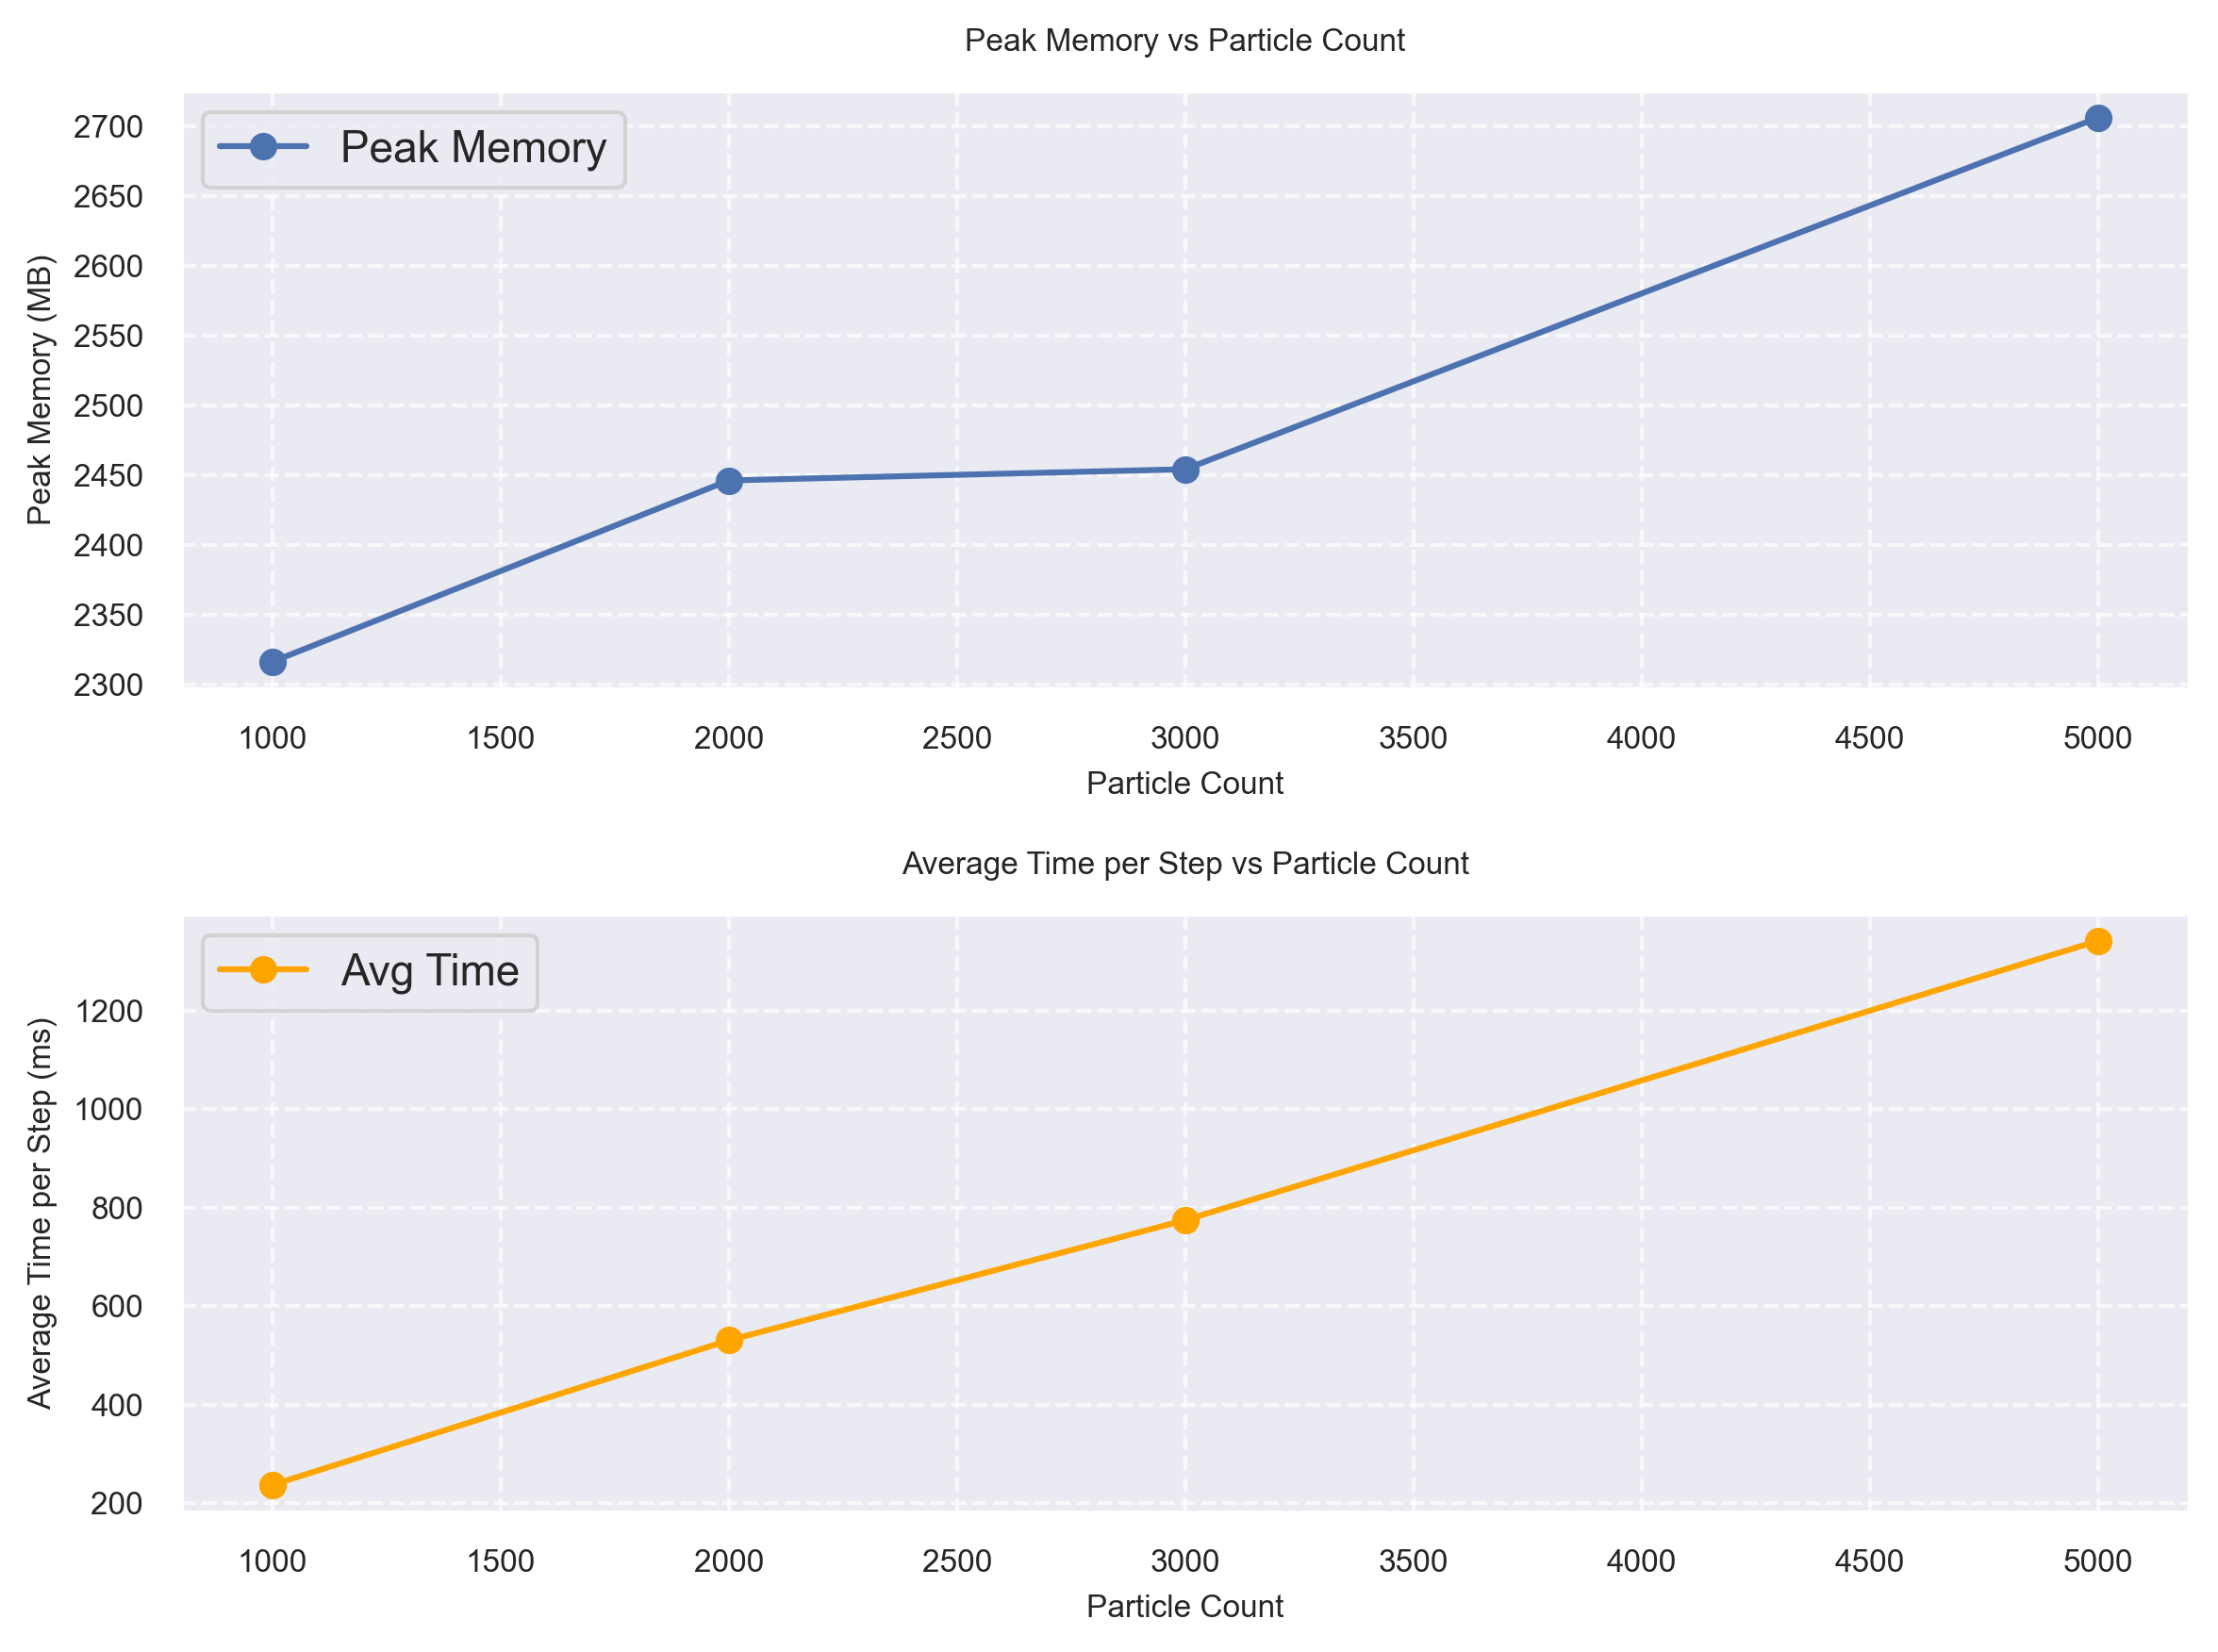

In [284]:
# Path to your CSV file
csv_path = STATS_PATH

# Generate the plots and summary table
plot_trends_from_csv(STATS_PATH)